---
## Loading Data


In [ ]:
import nltk
from nltk.corpus import webtext
nltk.download('webtext')

print(webtext.fileids())
print(len(webtext.raw('singles.txt'))) 
print(webtext.raw('firefox.txt').strip()[:100]) 

input_txt_corpus = webtext.raw('firefox.txt')

[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Package webtext is already up-to-date!
['firefox.txt', 'grail.txt', 'overheard.txt', 'pirates.txt', 'singles.txt', 'wine.txt']
21302
Cookie Manager: "Don't allow sites that set removed cookies to set future cookies" should stay check


In [ ]:
import re
from collections import Counter

def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences/ frequencies 
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

def lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

## Pre-processing
The `preprocess` function does a few things:
>* It converts any punctuation into tokens, so a period is changed to ` <PERIOD> `. 
* It removes all words that show up five or *fewer* == 5  times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
* It returns a list of words in the text.


In [ ]:
# get list of words
words = preprocess(input_txt_corpus)
print(words[:30])

print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

['cookie', 'manager', '<COLON>', '<QUOTATION_MARK>', "don't", 'allow', 'sites', 'that', 'set', 'removed', 'cookies', 'to', 'set', 'cookies', '<QUOTATION_MARK>', 'should', 'stay', 'checked', 'when', 'in', 'full', 'screen', 'mode', 'pressing', 'should', 'open', 'a', 'new', 'browser', 'when']
Total words in text: 87040
Unique words: 1513


### Create Vocab/ Dictionary

In [ ]:
vocab_to_index, index_to_vocab = lookup_tables(words)
index_words = [vocab_to_index[word] for word in words]

print(words[:30])
print(index_words[:30])

['cookie', 'manager', '<COLON>', '<QUOTATION_MARK>', "don't", 'allow', 'sites', 'that', 'set', 'removed', 'cookies', 'to', 'set', 'cookies', '<QUOTATION_MARK>', 'should', 'stay', 'checked', 'when', 'in', 'full', 'screen', 'mode', 'pressing', 'should', 'open', 'a', 'new', 'browser', 'when']
[262, 39, 16, 1, 120, 223, 239, 108, 125, 619, 233, 3, 125, 233, 1, 31, 620, 592, 6, 2, 263, 144, 271, 499, 31, 23, 8, 25, 34, 6]


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by [Mikolov[1]](https:/ arxiv.org/abs/1310.4546). For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter or prefer it saying learning_rate and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

> Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [ ]:
from collections import Counter
import random
import numpy as np

learning_rate = 1e-5
word_counts = Counter(index_words)
print("The word index 262 which is a word of Cookie apears 58 times in this text corpus")
print(list(word_counts.items())[0])  # dictionary of index_words, and how many times they appear

total_count = len(index_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(learning_rate/freqs[word]) for word in word_counts}

# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in index_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

The word index 262 which is a word of Cookie apears 58 times in this text corpus
(262, 58)
[108, 619, 271, 6, 735, 764, 1237, 57, 27, 242, 1147, 224, 856, 12, 1355, 534, 126, 24, 368, 421, 481, 162, 218, 1357, 24, 1355, 273, 574, 488, 259]


##  Build Batch for training

With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

- Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples.

- If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from previous words and $R$ words from the future words and make the Word as correct labels."


Generate Targets 
`get_target` function receives a list of words, an index, and a window size, then returns a list of words in the window around the index. 

In [ ]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [ ]:
# testing the code!
# run this cell multiple times to check for random window selection

ind_text = [i for i in range(10)]
print('Input: ', ind_text)
idx = 5 # word index of interest

target = get_target(ind_text, idx=idx, window_size=5)
print('Target: ', target)  #indices around the idx
print("Here is We are getting our target words at index 4 & 5")

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [0, 1, 2, 3, 4, 6, 7, 8, 9]
Here is We are getting our target words at index 4 & 5


### Generating Batches 

Here's a generator function that returns batches of input and target data for our model, using the `get_target` function from above. The idea is that it grabs `batch_size` words from a words list. Then for each of those batches, it gets the target words in a window.

In [ ]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets)  with a window-size = 5'''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [ ]:
id_txt = [i for i in range(20)]
x,y = next(get_batches(id_txt, batch_size=4, window_size=5))

print("target_words_id, Index_words_id")
print('x\n', x)
print('y\n', y)

target_words_id, Index_words_id
x
 [0, 1, 1, 1, 2, 2, 3, 3, 3]
y
 [1, 0, 2, 3, 1, 3, 0, 1, 2]


## Cosine (Similarity)

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [ ]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):

    # calculating the cosine similarity between some random words and embedding vectors.  
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

---
# SkipGram model

An Embedding layer takes in a number of inputs, importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension


>* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer. 

We'll use the softmax layer to make a prediction about the context words by sampling, as usual.

---
## Negative Sampling

For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct example, but only a small number of incorrect, or noise, examples. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). 

There are two modifications we need to make. First, since we're not taking the softmax output over all the words, we're really only concerned with one output word at a time. Similar to how we use an embedding table to map the input word to the hidden layer, we can now use another embedding table to map the hidden layer to the output word. Now we have two embedding layers, one for input words and one for output words. Secondly, we use a modified loss function where we only care about the true example and a small subset of noise examples.

$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

This is a little complicated so I'll go through it bit by bit. $u_{w_O}\hspace{0.001em}^\top$ is the embedding vector for our "output" target word (transposed, that's the $^\top$ symbol) and $v_{w_I}$ is the embedding vector for the "input" word. Then the first term 

$$\large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)}$$

says we take the log-sigmoid of the inner product of the output word vector and the input word vector. Now the second term, let's first look at 

$$\large \sum_i^N \mathbb{E}_{w_i \sim P_n(w)}$$ 

This means we're going to take a sum over words $w_i$ drawn from a noise distribution $w_i \sim P_n(w)$. The noise distribution is basically our vocabulary of words that aren't in the context of our input word. In effect, we can randomly sample words from our vocabulary to get these words. $P_n(w)$ is an arbitrary probability distribution though, which means we get to decide how to weight the words that we're sampling. This could be a uniform distribution, where we sample all words with equal probability. Or it could be according to the frequency that each word shows up in our text corpus, the unigram distribution $U(w)$. The authors found the best distribution to be $U(w)^{3/4}$, empirically. 

Finally, in 

$$\large \log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)},$$ 

we take the log-sigmoid of the negated inner product of a noise vector with the input vector. 

To give you an intuition for what we're doing here, remember that the sigmoid function returns a probability between 0 and 1. The first term in the loss pushes the probability that our network will predict the correct word $w_O$ towards 1. In the second term, since we are negating the sigmoid input, we're pushing the probabilities of the noise words towards 0.

In [ ]:
import torch
from torch import nn
import torch.optim as optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using "+device+ " for training this model")

We are using cuda for training this model


In [ ]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab,n_embed)
        self.out_embed = nn.Embedding(n_vocab,n_embed)
        
        # Initialize both embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1,1)
        self.out_embed.weight.data.uniform_(-1,1)
        
    def forward_input(self, input_words):
        # return input vector embeddings
        input_vector = self.in_embed(input_words)
        return input_vector
    
    def forward_output(self, output_words):
        # return output vector embeddings
        output_vector = self.out_embed(output_words)

        return output_vector
    
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        
        # as we are adding the noise to the output, so we will create the noise vector using the output embedding layer
        noise_vector = self.out_embed(noise_words).view(batch_size,n_samples,self.n_embed)        
        return noise_vector

In [ ]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors ==  batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors == batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # here bmm = batch matrix multiplication
        # correct log-sigmoid loss

        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        #debugging
        #print(type(noise_vectors)) #it is a tensor
        
        #'neg' returns the negative of a tensor
        #print(noise_vectors)
        #print(noise_vectors.neg())
        
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        
        return -(out_loss + noise_loss).mean()

### Training

Below is our training loop, and I recommend that you train on GPU, if available.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook

word_freqs = np.array(sorted(freqs.values(), reverse=True))
print(len(word_freqs))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))     ## used in the paper as negative sampling where they used f(word_freqs)^3/4 

# instantiating the model
embedding_dim = 100
model = SkipGramNeg(len(vocab_to_index), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1500
steps = 0
epochs = 30
batch =5

1513


In [ ]:
# train for some number of epochs
for e in range(epochs):
  # get our input, target batches
  for input_words, target_words in get_batches(train_words, batch):
    steps += 1
    inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
    inputs, targets = inputs.to(device), targets.to(device)
    
    # input, outpt, and noise vectors
    input_vectors = model.forward_input(inputs)
    output_vectors = model.forward_output(targets)
    noise_vectors = model.forward_noise(inputs.shape[0], 5)

    # negative sampling loss
    loss = criterion(input_vectors, output_vectors, noise_vectors)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # loss stats
    if steps % print_every == 0:
      print("Epoch: {}/{}".format(e+1, epochs))
      print("Loss: ", loss.item())                                                                       # avg batch loss at this point in training
      valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
      _, closest_idxs = valid_similarities.topk(6)
        
      valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
      for ii, valid_idx in enumerate(valid_examples):
        closest_words = [index_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
        print(index_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
      print("...\n")

Epoch: 1/30
Loss:  8.31590747833252
can't | firefox, ctrl+w, visible, right-click, error
this | loop, skin, shouldn't, script, management
not | cvs, launch, quickly, migration, than
to | tabbing, everything, empty, drawn, plugin
password | chars, connection, below, 2003, contain
all | exists, xp, ibm, blocked, do
firefox | can't, strict, ctrl+w, history, starts
for | select, background, selection, centered, any
quickly | not, every, app, server, options
garbled | small, see, closes, position, destination
modern | applet, text, tar, holding, because
crashing | most, control, wish, blue, occurs
produces | pages, talkback, each, dialogs, check
management | parent, this, amount, quickly, manually
finishes | paint, filename, redirects, rfe, write
anchor | standard, happens, tags, fault, middle
...

Epoch: 2/30
Loss:  4.819632530212402
at | generates, is, middle, pass, manual
doesn't | empty, cache, hide, picture, dialog
web | loading, viewing, a, is, off
can't | firefox, error, visible, rig

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

In [ ]:
viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


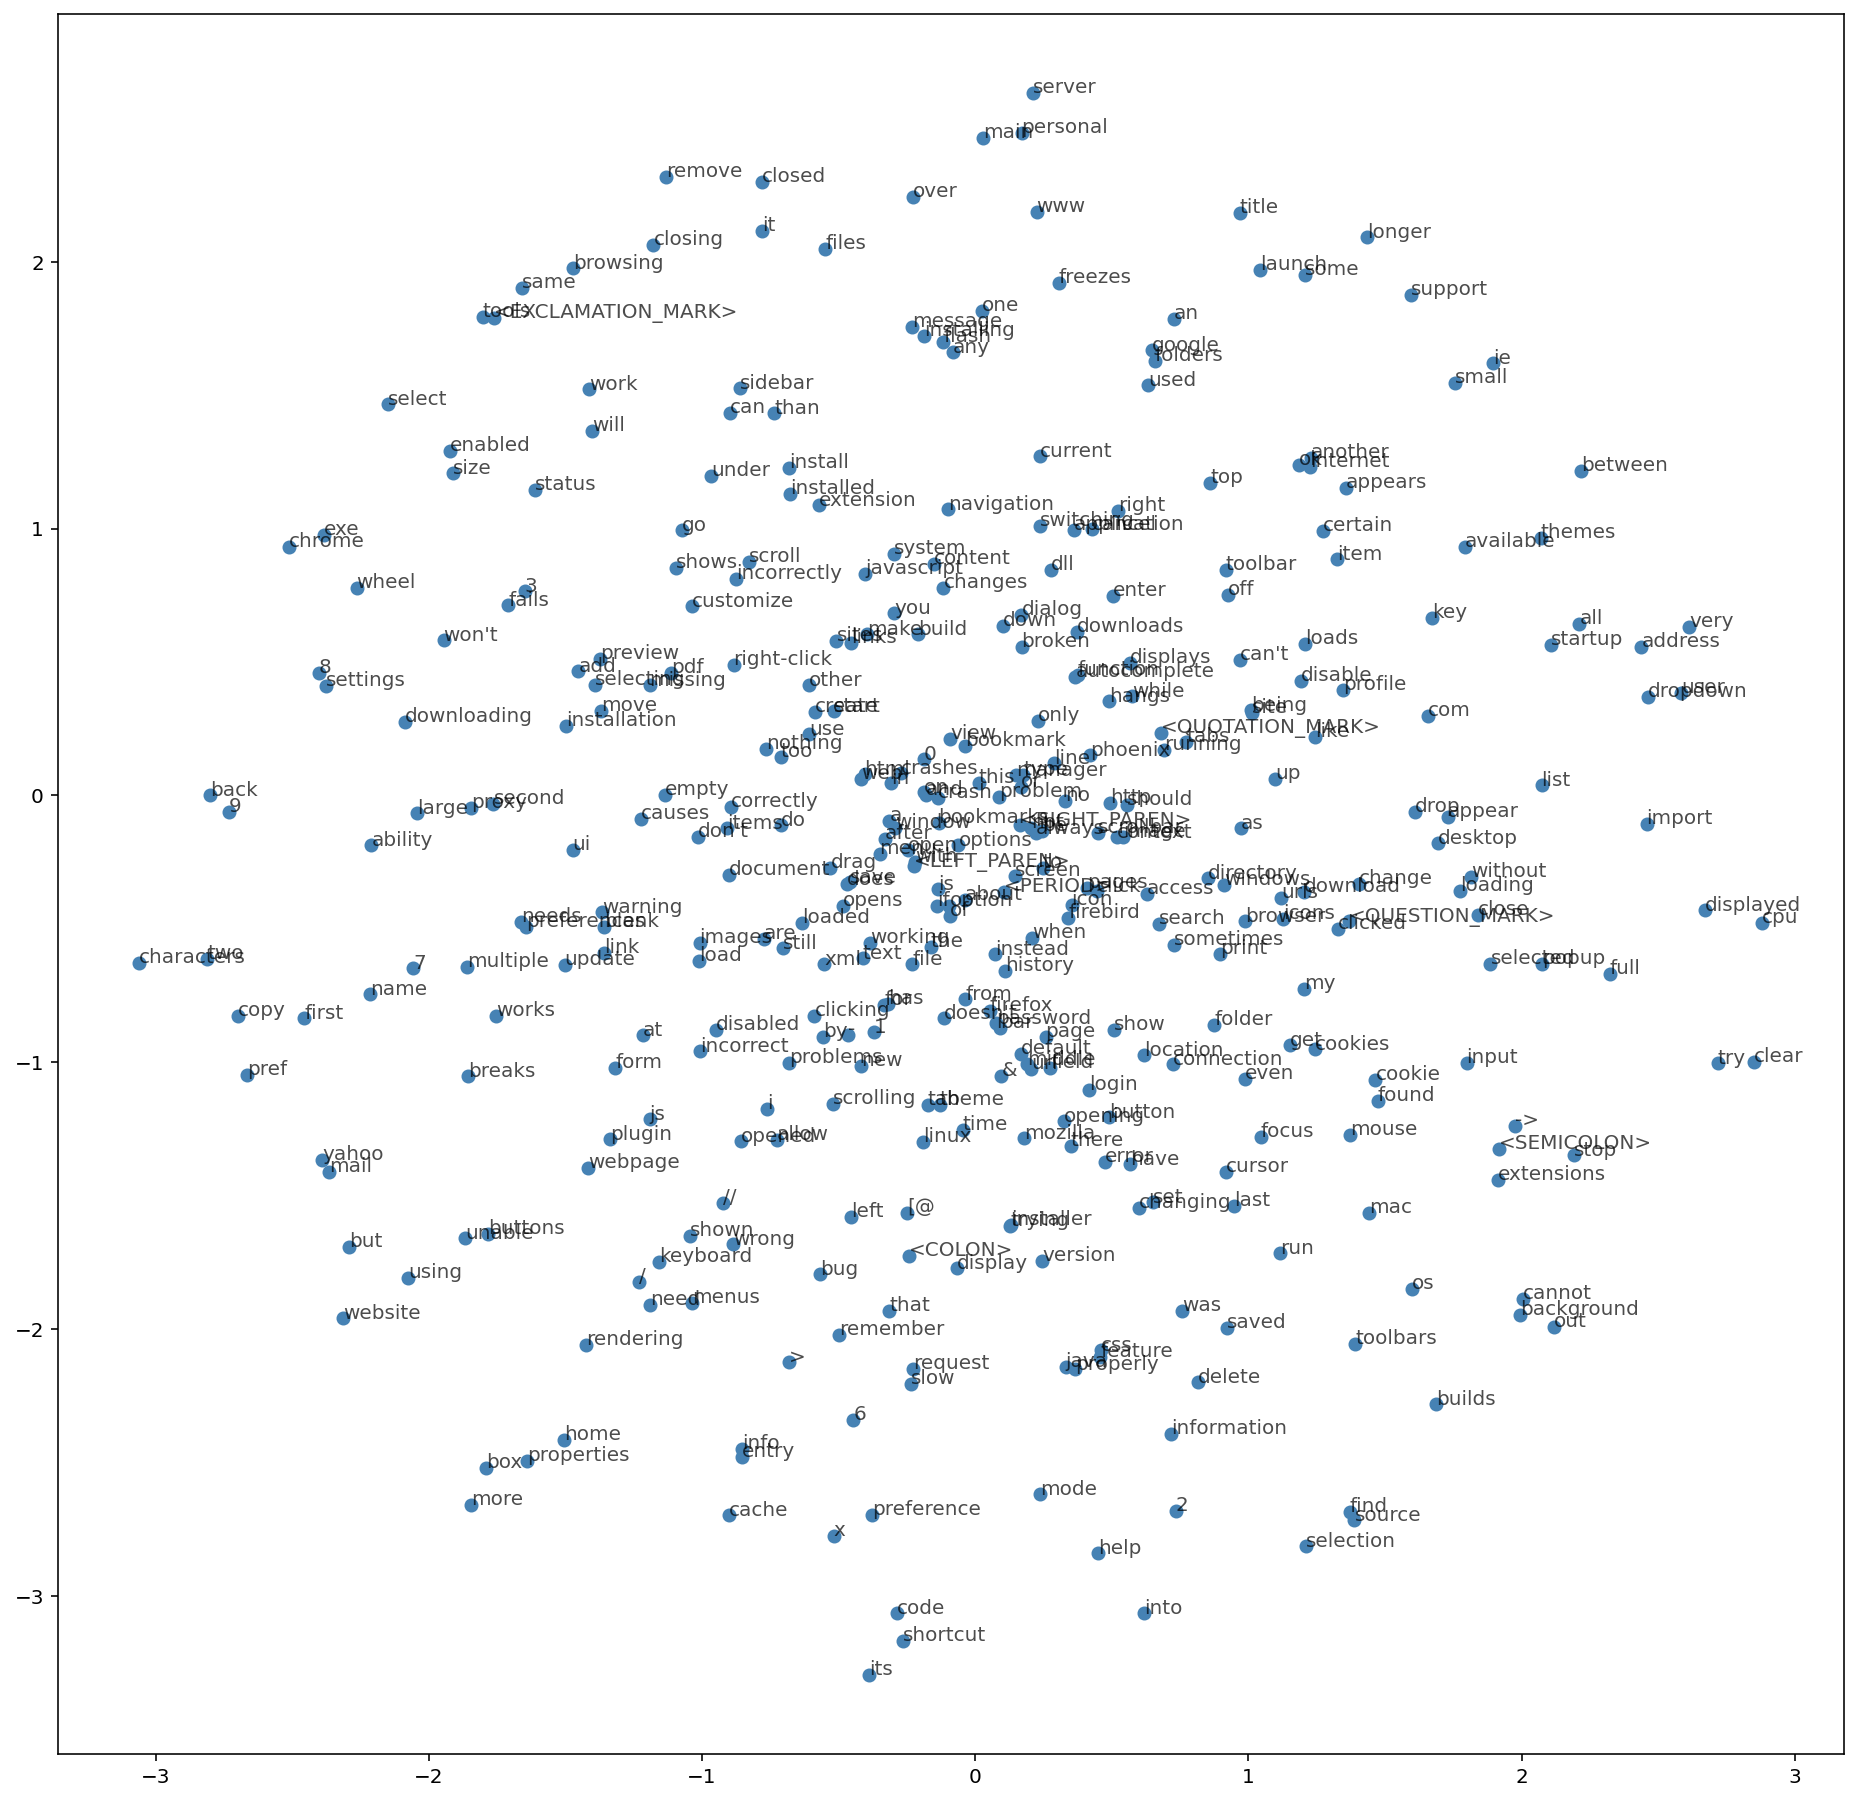

In [ ]:
fig, ax = plt.subplots(figsize=(32, 32))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(index_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
    plt.imsave("viz.png")